# Brain MRI Inpainting

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Hobit2002/BraTS_JKU_10a/blob/main/Colab_interface.ipynb)

## Clone the repository

In [ ]:
# prompt: clone the follwoing repo: https://github.com/BraTS-inpainting/2023_challenge/tree/main/baseline

!git clone https://github.com/BraTS-inpainting/2023_challenge.git brats_challenge
!cd 2023_challenge
!git checkout main
!cd baseline


Cloning into 'brats_challenge'...
remote: Enumerating objects: 311, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 311 (delta 22), reused 8 (delta 3), pack-reused 262 (from 1)
Receiving objects: 100% (311/311), 6.80 MiB | 24.08 MiB/s, done.
Resolving deltas: 100% (160/160), done.
/bin/bash: line 1: cd: 2023_challenge: No such file or directory
fatal: not a git repository (or any of the parent directories): .git
/bin/bash: line 1: cd: baseline: No such file or directory


## Install the dependencies

In [ ]:
# prompt: I need the following dependencies:
# torch and torchvision which are compatible with your cuda version (See https://pytorch.org/). Note however, that for pytorch<1.13, you might encounter issues with our code. Use pytorch>=2.0.0 if possible
# pytorch-lightning
# matplotlib
# nibabel
# tensorboard
# jupyter
# scipy
# tqdm

# ## Install the dependencies
!pip uninstall -y  torch torchvision torchaudio
!pip install  --no-cache-dir torch --index-url https://download.pytorch.org/whl/cu118
!pip install --no-cache-dir torchvision --index-url https://download.pytorch.org/whl/cu118
!pip install --no-cache-dir torchaudio --index-url https://download.pytorch.org/whl/cu118
# For CUDA 11.7, use cu117 instead of cu118 in the above command.  Adjust accordingly for other CUDA versions.
# If you have issues with CUDA, try installing without CUDA:
# !pip install torch torchvision torchaudio

!pip install pytorch-lightning
!pip install matplotlib
!pip install nibabel
!pip install tensorboard
!pip install jupyter
!pip install scipy
!pip install tqdm


Found existing installation: torch 2.5.1+cu124
Uninstalling torch-2.5.1+cu124:
  Successfully uninstalled torch-2.5.1+cu124
Found existing installation: torchvision 0.20.1+cu124
Uninstalling torchvision-0.20.1+cu124:
  Successfully uninstalled torchvision-0.20.1+cu124
Found existing installation: torchaudio 2.5.1+cu124
Uninstalling torchaudio-2.5.1+cu124:
  Successfully uninstalled torchaudio-2.5.1+cu124
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 238.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 322.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 253.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 254.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 225.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 169.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Download the dataset

In [ ]:
# prompt: connect to my local google drive folder sample_scans and copy tohe folder to current directory

from google.colab import drive
drive.mount('/content/drive')

!cp -r "/content/drive/My Drive/sample_scans" "/content/brats_challenge"


Mounted at /content/drive


## Imports and Parameters

In [ ]:
import os

os.chdir("/content/brats_challenge/baseline")

# Diverse
from pathlib import Path
import numpy as np
from tqdm import tqdm

# Datasets
from dataset3D import Dataset_Training, Dataset_Inference

# Training
import torch
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import pytorch_lightning as pl
from baseline_utils import plot_3D
import nibabel as nib

# Models
from baseline_utils import get_latest_Checkpoint  # to load last checkpoint
from train_Pix2Pix3D import Pix2Pix3D
from train_AE import AutoEncoder

# Processes
import subprocess
import sys

# Path to training dataset
dataset_path = Path("../sample_scans")

# Seed (For the random number generator. Use this seed to reproduce our output)
seed = 2023
np.random.seed(2023)  # set seed for notebook.

# Crop shape (how big is the cuboid the network is trained on)
crop_shape = (128, 128, 96)  # most bounding boxes should fit easily into this volume


### Inspect the data
---



In [ ]:
datasetInf = Dataset_Inference(dataset_path, crop_shape=(240, 240, 155))  # Full images
datasetTrain = Dataset_Training(dataset_path, crop_shape=(240, 240, 155))  # Full images


print(f"Dataset size: {len(datasetTrain)}")
print(f"\tImage shape: {datasetTrain[0]['voided_healthy_image'].shape}")
# Shape: Channel x X(Width) x Y(length/Depth) x Z(Height) -> CWDH

print(f"Training Data: {list(datasetTrain[0].keys())}")
print(f"Inference Data: {list(datasetInf[0].keys())}")

Dataset size: 6
	Image shape: torch.Size([1, 240, 240, 155])
Training Data: ['gt_image', 'voided_healthy_image', 't1n_path', 'healthy_mask', 'healthy_mask_path', 'cropped_bbox', 'max_v', 'name']
Inference Data: ['voided_image', 't1n_voided_path', 'mask', 'cropped_bbox', 'max_v', 'name']


### Example Figure: Full Brain Sample

Lets create a dataset with complete (full size) brain samples (**240x240x155**) to get an idea how the samples looks like.

However, for training our baseline model, full sized brain samples are **too big**! We use cropped brain samples (see next section).


BraTS-GLI-01662-000: t1n + mask-healthy:


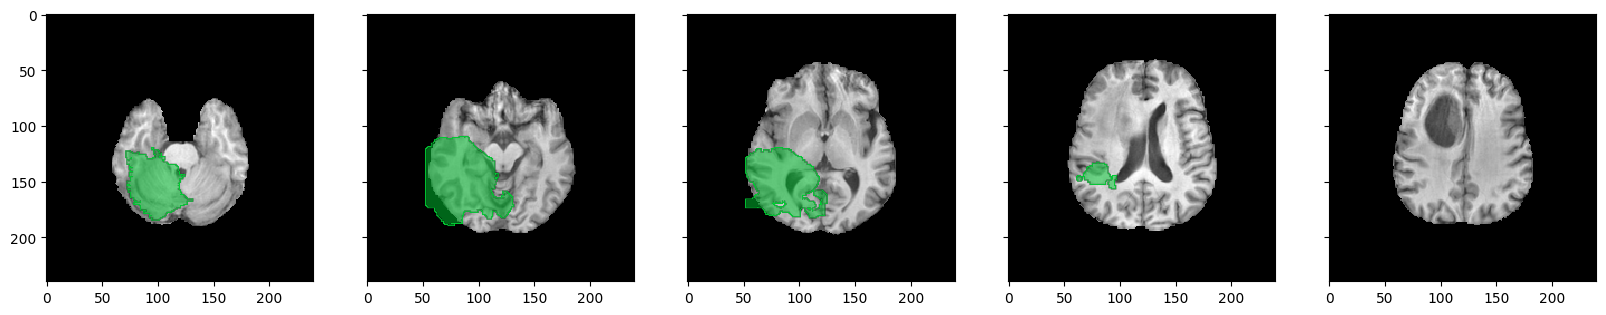

BraTS-GLI-01662-000: t1n-voided-healthy:


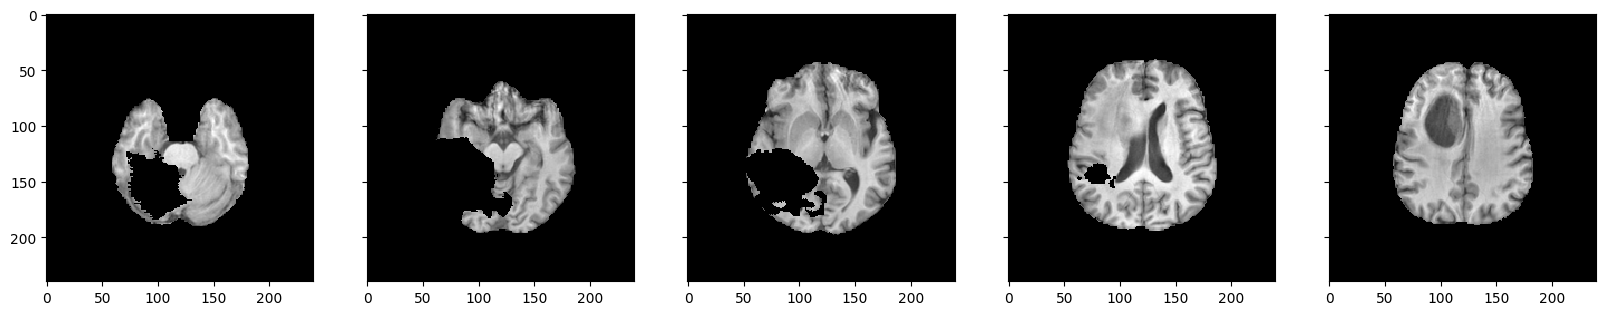

In [ ]:
# Get random sample
random_index = np.random.randint(0, len(datasetTrain) - 1)
sample_data = datasetTrain[random_index]

# Plot: t1n, t1n-voided-healthy
print(f"{sample_data['name']}: t1n + mask-healthy:")
plot_3D(sample_data["gt_image"], healthyMask=sample_data["healthy_mask"])
print(f"{sample_data['name']}: t1n-voided-healthy:")  # t1n where the healthy mask is voided
plot_3D(sample_data["voided_healthy_image"])

### Example Figure: Cropped Sample

Now we create the cropped version of our brain sample training dataset. It consits of cropped brain samples (**128x128x96**) centered around the infill mask.  


Created training dataset with crop shape: (128, 128, 96)
BraTS-GLI-01662-000: t1n + mask-healthy:


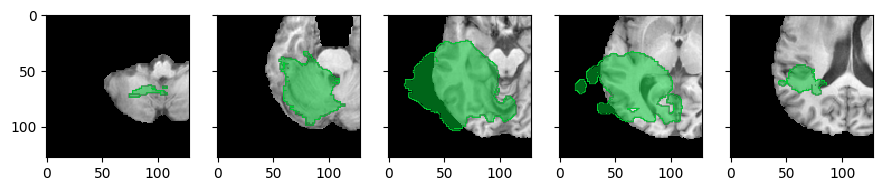

BraTS-GLI-01662-000: t1n-voided-healthy:


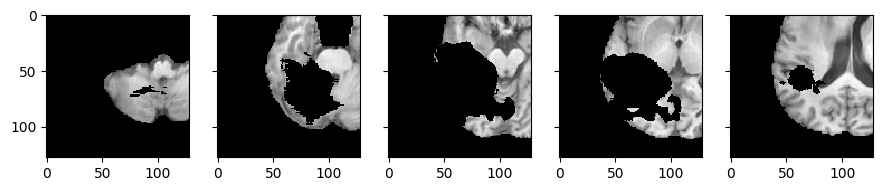

In [ ]:
# Create Dataset
datasetTrain_cropped = Dataset_Training(dataset_path, crop_shape=crop_shape, center_on_mask=True)
print(f"Created training dataset with crop shape: {crop_shape}")

# plot random sample
random_index = np.random.randint(0, len(datasetTrain_cropped) - 1)
sample_data = datasetTrain_cropped[random_index]

print(f"{sample_data['name']}: t1n + mask-healthy:")
plot_3D(sample_data["gt_image"], healthyMask=sample_data["healthy_mask"])
print(f"{sample_data['name']}: t1n-voided-healthy:")
plot_3D(sample_data["voided_healthy_image"])

### Download the model

In [ ]:
# prompt: Download the following link and extract it to brats_challenge/baseline: https://syncandshare.lrz.de/dl/fiWmxMzsnrWyY3yAja85JE/lightning_logs.zip

import os
from pathlib import Path

# Create the directory if it doesn't exist
output_dir = Path("brats_challenge/baseline")
output_dir.mkdir(parents=True, exist_ok=True)

# Download the zip file
!wget https://syncandshare.lrz.de/dl/fiWmxMzsnrWyY3yAja85JE/lightning_logs.zip -O lightning_logs.zip

# Extract the zip file to the specified directory
!unzip lightning_logs.zip -d brats_challenge/baseline


--2025-03-12 08:07:26--  https://syncandshare.lrz.de/dl/fiWmxMzsnrWyY3yAja85JE/lightning_logs.zip
Resolving syncandshare.lrz.de (syncandshare.lrz.de)... 129.187.255.213
Connecting to syncandshare.lrz.de (syncandshare.lrz.de)|129.187.255.213|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1941826588 (1.8G) [application/x-zip-compressed]
Saving to: ‘lightning_logs.zip’

lightning_logs.zip    0%[                    ]   9.98M   555KB/s    eta 59m 15s^C
Archive:  lightning_logs.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of lightning_logs.zip or
        lightning_logs.zip.zip, and cannot find lightning_logs.zip.ZIP, period.


### Load Model & Infer Results

If you want to load your model, you can use the following code. This might be especially useful for testing the model in different scenarios.

#### Using the trained baseline model
If you do not wish to train the baseline model anew, we recommend that you [download the baseline model](https://syncandshare.lrz.de/getlink/fiQJMJPUCUBj1vmvxCdWY4/lightning_logs.zip) we already trained.



In [ ]:
# Setup evaluation dataset
torch.manual_seed(seed)  # same seeding ensure we end up with the same split
eval_dataset = Dataset_Inference(dataset_path, crop_shape=crop_shape, center_on_mask=True)

# Get latest model checkpoint
latest_checkpoint = get_latest_Checkpoint(modelName, version="*")
if latest_checkpoint == None:
    raise UserWarning("No latest model found!")
else:
    print(f"Latest checkpoint: {latest_checkpoint}")

# Load your model
model = Pix2Pix3D.load_from_checkpoint(latest_checkpoint, map_location=torch.device("cuda"))
model.eval()  # Make drop-out/Norms and other deterministic
model.cuda()  # Move to GPU

# Choose Sample(s)
sample = eval_dataset[np.random.randint(0, len(eval_dataset) - 1)]
# for sample in tqdm(eval_dataset):
print(sample["name"])

# Inference
voided_image = sample["voided_image"].unsqueeze(0)  # add batch (1, 160, 160, 96) -> (1, 1, 160, 160, 96)
mask = sample["mask"].unsqueeze(0)
with torch.no_grad():
    prediction = model.forward(voided_image.cuda(), mask.cuda())
    result, image = eval_dataset.get_result_image(prediction[0].cpu().numpy(), sample)  # returns 3D image (X,Y,Z)

# Get ground truth and voided (for comparison)
t1n_path = dataset_path.joinpath(sample["name"]).joinpath(f"{sample['name']}-t1n.nii.gz")
t1n = nib.load(t1n_path).get_fdata()
voided_image_path = dataset_path.joinpath(sample["name"]).joinpath(f"{sample['name']}-t1n-voided.nii.gz")
voided_image = nib.load(voided_image_path).get_fdata()
mask_path = dataset_path.joinpath(sample["name"]).joinpath(f"{sample['name']}-mask.nii.gz")
mask = nib.load(mask_path).get_fdata()

# Show Sample
print(f"{sample['name']}: t1n + mask:")
plot_3D(t1n, generalMask=mask)
print(f"{sample['name']}: t1n-voided:")
plot_3D(voided_image)
print(f"{sample['name']}: t1n-inference:")  # the model output
plot_3D(result)
print(f"{sample['name']}: t1n:")  # the t1n image for comparison
plot_3D(t1n)

## Monitoring Progress - TensorBoard

We use TensorBoardLogger for visualization and logging. To start tensorboard, open a separate command line and navigate to ```baseline/``` where you extracted ```lightning_logs/``` to (this is the baseline model you downloaded from [here](https://syncandshare.lrz.de/dl/fiWmxMzsnrWyY3yAja85JE/lightning_logs.zip)).  Then start tensorboard by executing ```tensorboard --logdir lightning_logs/ --port 6006```

Now you can open a web browser and access the website ```http://localhost:6006```

In **scalars** you see the logged **losses** and in **images** you see the images generated by **validation**

The training logs as well as the **checkpoint files** can be found under ```/lightning_logs/{name}/version_*```. Here, ```{name}``` is either "Pix2Pix3D" or "AutoEncoder" (see the following two sections).

**COMPABILITY NOTE:** During testing this repository, we noticed that training does freeze when tensorboard is started before/during training. If you encounter the same issue, try to shutdown tensorboard and only open it when required. Or, alternatively, copy the lightning logs to a different folder where only tensor board is operating on.

In case you find a solution to this issue, please let us know! (e.g. over the Synapse forum or in a GitHub issue)

In [ ]:
! tensorboard --logdir baseline/lightning_logs/ --port 6006

2025-03-12 08:09:42.530709: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-12 08:09:42.550436: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741766982.572412    2525 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741766982.579065    2525 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-12 08:09:42.601546: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Training - Pix2Pix

As training in this notebook might be cumbersome (and not easily transferable to an HPC server), we outsource the training into ```baseline/train_Pix2Pix3D.py```.
In the following, we define the parameters for training and start a subprocess for training with them as arguments.

In case you **struggle** with setting up Pix2Pix, you might want to first to get the **Autoencoder** running (next section). It is less complex, needs less VRAM and training should be faster.

In [ ]:
!python3 train_Pix2Pix3D.py --epochs 3 --dataset ../sample_scans --batch-size 2 --accelerator gpu --gpus 0 --seed 2023 --split 0.8 0.2 --crop-shape 128 128 96 --ckpt-path None

Namespace(epochs=3, batch_size=2, dataset_path='../sample_scans', accelerator='gpu', gpus=[0], seed=2023, split=[0.8, 0.2], crop_shape=[128, 128, 96], ckpt_path='None')
Running on gpu:
	[0]: NVIDIA A100-SXM4-40GB
Seed: 2023
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
######################################
experiment_name: Pix2Pix3D
######################################
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize t